# Minimal working example for cokringing of a scalar field for geological modeling

The aim of this notebook is to explain in simple steps the scalar-field (or: potential-field) interpolation implemented in GemPy and GeoModeller, based on Lajaunie et al. (1997) and Calcagno et al. (2008).

## Basic principle behind a scalar-field interpolation

The method is based on a zonation principle, i.e. a segmentation of continuous space into discrete zones with similar properties (or other aspects of interest). Typical examples are the distinction of rock units with different lithological features (e.g. different types of sandstones, clay layers, magmatic sequences, etc), but also metamorphic sequences that can be distinguished. Quite generally, it is basically the same concept that is underlying the construction of geological map.

The general idea behind this interpolation method is that geological structures exhibit a specific continuity. As a very basic first principle, we can consider the deposition of sedimentary sequences, for example in a marine environment: we may observe a sequence of more sand-dominated and more clay-dominated units. In a quiet and continuous sedimentation environment, we can assume that we have wide lateral continuity and a "layer-by-layer" deposition.

In the context of geomodeling, we may attempt to describe now these sedimented zones by the interface surfaces between them. It is then obvious that these surfaces should not cross (considering no disturbance during sedimentation). Furthermore, we can assume that the layers show a specific influence on each other: to first order, they can be considered as parallel. And, maybe for a finer distinction, we can assume that a (topographic) variability of in one layer (for example a sea mound, to stay in our example) has a certain upward continuation and can potentially still be apparent (though to a lesser extent) on the next interface above.

We can now take a more abstract view and assume that we do not only two or three interfaces, but more or less a continuous description of subsequent layers, representing a continuous sedimentation process and showing a similar continuous influence on each other, and the layer interfaces can not cross. 

With this intuition, we can describe these layer interfaces as isosurfaces in a scalar field. In our example, we can even interpret the scalar field values as related to a specific depositional age (note that this notion will not generally be possible - nor a requirement). Even further, we can interpret the gradient of this scalar field as orientation values, i.e. measurements of strike/ dip/ dip direction in a geological sequence.

The question now is: how can we interpolate this scalar field from a set of limited observations of surface contact points and orientation measurements?

## Notation and scalar field interpolation

Multiple methods are possible to obtain this scalar field. A very common approach (mostly from the field of image segmentation, but also applied in geophysics) is to use a Level Set formulation (Chan & Vese?). Other previous approaches implemented Radial Basis Functions (RBF's, e.g. the implementation in LeapFrog, see also Hillier, 2014) and a stochastic time interpretation (? Mallet 2004 - the GoCAD implicit modeling approach). We use here a geostatistical method based on (universal) co-kriging, described in Lajaunie et al., 1997.

We denote the 3-D surface in an *implicit* form (therefore also the name of these methods as "implicit geomodeling"), associated with a function $\psi_\alpha$ such that (Lajaunie et al., 1997):

$$C_\alpha = \{x : \psi_a(x) = 0 \}$$


We describe the scalar field that we aim to obtain as a function $T( \vec{x} )$. 

Next, we denote $Z$ as a realization of the (differentiable) random function $\psi$. We now use a kriging method to to estimate $Z$ in the entire domain of interest.

Note: important basic principle: multivariate (co-)kriging, IRK-f model (Matheron!) CHECK!!

However, co-kriging is not "standard" form, as variables are algebraically linked!

More notation:

Gradient data:

$$\frac{\partial Z}{\partial x} (x_i) = G_i^x$$

$$\frac{\partial Z}{\partial y} (x_i) = G_i^y$$

Tangent vector $\tau_i$ is defined through a scalar product:

$$ <\nabla Z(x_i), \tau_i > = 0$$

Points on a single interface belong to a single set $J_k$, $k$ is the index of the interface.

Increments for points on a single interface, the increments must be zero:

$$Z(x_j) - Z(x_{j'}) = 0 \;\;\forall (j,j') \in J_k$$


### The spatial model

As we only consider increments, we can only obtain a (unique) solution when we fix/ select an arbitrary origin $x_0$ and we estimate increments with respect to this origin:

$$Z(x) - Z(x_0) = \sum_{i \in I} \left( \lambda_i G_i^x + \mu_i G_i^y  \right) + \sum_{i' + I'} <\nabla Z(x_{i'}), \tau_{i'} > + \sum_k \sum_{jj' \in \mathcal{P}(J_k)} \lambda_{jj'}[Z(x_j) - Z(x_{j'})] $$ 


$\mathcal{P}(J_k)$ is the set of pairs associated with one interface $J_k$.

We now have to set up the kriging equation to solve for the parameters/ coefficients $\lambda_i, \mu_i, \lambda_{jj'}$ in order to obtain an (explicit?) equation that we can use to determine the potential field value at any point in space.

### Covariance functions

The situation is (a "bit") complicated by the fact that we have to consider all covariances and cross-covariances of each function involved.


(Side note/ Idea/ Check: can the same form of co-kriging be used in the context of posterior-space estimation/ reduced order modeling, etc. - i.e. all the cases where kriging is used, also ML? Because: we could estimate the gradient quite easily using AD-methods and the approach could lead to a more robust estimate? )

For simplicity in the description, we consider an isotropic covariance field. We follow the description in Lajaunie et al. (1997) and denote the covariance of $Z$ as $K_Z$. Furthermore, a vector connecting two points in space is:

$$\vec{h} = \vec{x} - \vec{y}$$

And the components of this vector in $x$- and $y$-direction respectively are $h_x$ and $h_y$. The base covariance function is:

$$K_Z(\vec{h}) = C_Z(r)$$

In order for $Z$ to be differentiable, $K_Z$ must be twice differentiable. Under these conditions (??), the covariances are:

$$K_{ZG^x}(\vec{x} - \vec{y})= Cov(Z(x),Z_x'(y)) = - \frac{h_x}{r} C_Z'(r)$$

Similar:

$$K_{G^x G^y}((\vec{x} - \vec{y})$$

$$K_{G^x}((\vec{x} - \vec{y})$$

As a first test, we use the covariance functions defined in Lajaunie et al. for the Gaussian model (pg. 578):

If

$$C(r) = \exp{-(r/a)^2}$$
then:

$$K_{ZG^x}(\vec{h}) = -2 \frac{h_x}{a^2} C(r)$$

$$K_{G^x}(\vec{h}) = \left(\frac{2}{a^2} - 4 \frac{x^2}{a^4}  \right) C(r)$$

$$K_{G^x G^y}(\vec{h}) = -4 \frac{h_x h_y}{a^4} C(r)$$

where $\vec{h} = \vec{x} - \vec{y}$, $r = |\vec{h}|$ and $h_x$ the component of $\vec{h}$ in $x$-direction, etc.

<div class="alert alert-info">
  <strong>To do (Miguel?):</strong> Include better covariance function (spline?).
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
# define covariance functions (note: no nugget effect so far...):


# Spline covariance - something wrong? At least, K_Z doesn't make sense..
# # cov space
# def K_Z(r, a=1.):
#     return (r/a)**4 * np.log(r/a)

# # cross-cov space-grad
# def K_ZGx(r, hx=1.):
#     return -hx * r**2 * (1 + 4 * np.log(r))

# def K_ZGx(r, hy=1.):
#     return -hy * r**2 * (1 + 4 * np.log(r))

# # cov grad
# def K_Gx(r, hx=1.):
#     return -6 * hx**2 - r**2 - (4 * r**2 + 8 * hx**2) * np.log(r)

# def K_Gy(r, hy=1.):
#     return -6 * hy**2 - r**2 - (4 * r**2 + 8 * hy**2) * np.log(r)

# # cross-cov grad
# def K_GxGy(r, hx=1., hy=1.):
#     return -2 * hx * hy * (3 + np.log(r))

def K_Z(r, a=5.):
    return np.exp(-(r/a)**2)
                  
# cross-cov space-grad
def K_ZGx(r, hx=5., a=5.):
    return -2 * hx/a**2 * K_Z(r,a) 

def K_ZGy(r, hy=5., a=5.):
    return -2 * hy/a**2 * K_Z(r,a) 

# cov grad
def K_Gx(r, hx=5, a=5.):
    return (2/a**2 - 4 * hx**2/a**4) * K_Z(r,a)

def K_Gy(r, hy=5., a=5.):
    return (2/a**2 - 4 * hy**2/a**4) * K_Z(r,a)

# cross-cov grad
def K_GxGy(r, hx=5., hy=5., a=5.):
    return -4 * hx * hy /a**4 * K_Z(r,a)

           
        



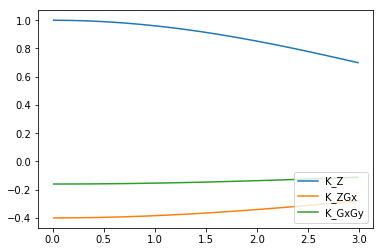

In [83]:
rs = np.arange(0.01,3,0.01)
plt.plot(rs, K_Z(rs), label='K_Z')
plt.plot(rs, K_ZGx(rs), label='K_ZGx')
# plt.plot(rs, K_ZGy(rs))
# plt.plot(rs, K_Gx(rs), label='K_Gx')
plt.plot(rs, K_GxGy(rs), label='K_GxGy')
plt.legend(loc='lower right')
plt.show()

<div class="alert alert-danger">
  <strong>Check:</strong> why are cross-covariances negative? Check theory!
</div>

### Universality conditions


(Miguel?)

### Dual form

Under the above conditions, we can actually write the kriging equations in the dual form and finally obtain the estimator:



## Simple example: 4 points, one gradient

We first start with a very simple example: twi interfaces iwth two points each, and one common gradient.

<div class="alert alert-warning">
  <strong>To do:</strong> Include sketch of points and gradient.
</div>

In [84]:
# interface points:
# interface 1:
x1 = [1,1]
x2 = [4,1]
x_int1 = np.vstack([x1,x2])
# interface 2:
x3 = [1,3]
x4 = [4,3]
x_int2 = np.vstack([x3,x4])
# orientation point:
x5 = [1,2]
x_all = np.vstack([x1, x2, x3, x4, x5])
# orientation values
gx5 = 1
gy5 = 1

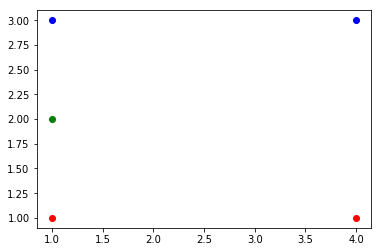

In [85]:
plt.plot(x_int1[:,0], x_int1[:,1], 'ro')
plt.plot(x_int2[:,0], x_int2[:,1], 'bo')
plt.plot(x5[0], x5[1], 'go')

### Calculate distance matrix

In [86]:
import scipy.spatial.distance as dist


In [87]:
d = dist.squareform(dist.pdist(x_all))

In [88]:
x_all,d

(array([[1, 1],
        [4, 1],
        [1, 3],
        [4, 3],
        [1, 2]]),
 array([[ 0.        ,  3.        ,  2.        ,  3.60555128,  1.        ],
        [ 3.        ,  0.        ,  3.60555128,  2.        ,  3.16227766],
        [ 2.        ,  3.60555128,  0.        ,  3.        ,  1.        ],
        [ 3.60555128,  2.        ,  3.        ,  0.        ,  3.16227766],
        [ 1.        ,  3.16227766,  1.        ,  3.16227766,  0.        ]]))

In [89]:
d[1,0], d[0,1]

(3.0, 3.0)

### Set up K matrix

In [90]:
K = np.array([[K_Gx(d[4,4]), K_GxGy(d[4,4]), K_ZGx(d[4,0])-K_ZGx(d[4,1]), K_ZGx(d[4,2])-K_ZGx(d[4,3])],
              [K_GxGy(d[4,4]), K_Gy(d[4,4]), K_ZGy(d[4,0])-K_ZGy(d[4,1]), K_ZGy(d[4,2])-K_ZGy(d[4,3])],
              [K_ZGx(d[0,4])-K_ZGx(d[1,4]), K_Gy(d[0,4])-K_ZGy(d[1,4]), K_Z(d[0,0])-K_Z(d[0,1])-K_Z(d[1,0])+K_Z(d[1,1]), K_Z(d[0,2])-K_Z(d[0,3])-K_Z(d[1,2])+K_Z(d[1,3])],
              [K_ZGx(d[0,4])-K_ZGx(d[1,4]), K_Gy(d[0,4])-K_ZGy(d[1,4]), K_Z(d[0,0])-K_Z(d[0,1])-K_Z(d[1,0])+K_Z(d[1,1]), K_Z(d[0,2])-K_Z(d[0,3])-K_Z(d[1,2])+K_Z(d[1,3])]])

In [91]:
K

array([[-0.08      , -0.16      , -0.11618776, -0.11618776],
       [-0.16      , -0.08      , -0.11618776, -0.11618776],
       [-0.11618776,  0.19126486,  0.60464735,  0.51524648],
       [-0.11618776,  0.19126486,  0.60464735,  0.51524648]])

### Set up F-matrix

In [92]:
F = np.array([[1, 0, x_all[0,0]-x_all[1,0], x_all[2,0]-x_all[3,0]],
              [0, 1, x_all[0,1]-x_all[1,1], x_all[2,1]-x_all[3,1]],
              [2*x_all[4,0], 0, x_all[0,0]**2-x_all[1,0]**2, x_all[2,0]**2-x_all[3,0]**2],
              [0, 2*x_all[4,1], x_all[0,1]**2-x_all[1,1]**2, x_all[2,1]**2-x_all[3,1]**2],
              [x_all[4,1], x_all[4,0], x_all[0,0]*x_all[0,1]-x_all[1,0]*x_all[1,1], x_all[2,0]*x_all[2,1]-x_all[3,0]*x_all[3,1]]])

In [93]:
F

array([[  1,   0,  -3,  -3],
       [  0,   1,   0,   0],
       [  2,   0, -15, -15],
       [  0,   4,   0,   0],
       [  2,   1,  -3,  -9]])

### Combine in full matrix

In [94]:
A = np.hstack([K, F.transpose()])
B = np.hstack([F, np.zeros((5,5))])
krig_full = np.vstack([A,B])

In [95]:
krig_full, krig_full.shape

(array([[ -0.08      ,  -0.16      ,  -0.11618776,  -0.11618776,
           1.        ,   0.        ,   2.        ,   0.        ,   2.        ],
        [ -0.16      ,  -0.08      ,  -0.11618776,  -0.11618776,
           0.        ,   1.        ,   0.        ,   4.        ,   1.        ],
        [ -0.11618776,   0.19126486,   0.60464735,   0.51524648,
          -3.        ,   0.        , -15.        ,   0.        ,  -3.        ],
        [ -0.11618776,   0.19126486,   0.60464735,   0.51524648,
          -3.        ,   0.        , -15.        ,   0.        ,  -9.        ],
        [  1.        ,   0.        ,  -3.        ,  -3.        ,
           0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   1.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
        [  2.        ,   0.        , -15.        , -15.        ,
           0.        ,   0.        ,   0.        ,   0.        , 

### Set up b-vector (RHS)

In [96]:
b = np.zeros(9)
b[0] = gx5
b[1] = gy5

In [97]:
b

array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Solve system of algebraic equations

In [98]:
np.linalg.solve(krig_full, b)

LinAlgError: Singular matrix

Bam!

In [99]:
np.linalg.inv(K)

LinAlgError: Singular matrix

In [100]:
krig_full.shape

(9, 9)

Why is the inversion failing? Problem with the setup of the universal part (I assume)? Or is the point configuration too similar?

Approach: try pseudo-inverse instead:

In [101]:
weights = np.dot(np.linalg.pinv(krig_full), b)

In [102]:
weights

array([ -1.25745042e-15,   4.62802214e-16,   3.39222441e-16,
        -5.05521233e-16,   1.66666667e+00,   5.88235294e-02,
        -3.33333333e-01,   2.35294118e-01,   4.73362669e-16])

Hmmm... some values are very small - no contribution from the gradients, especially... basically, only the drift values are considered?

Let's see: interpolate!

The weight vector now contains the parameters: $w = [a_5, b_5, c_{12}, c_{34}, d_1, d_2, d_3, d_4, d_5]$. 

In our example (at the moment), the solution seems to be completely determined by the drift value.

### Interpolate values

Use equation (1) on page 577 from Lajaune et al.:

$$Z(x_\alpha)^K = a_5 K_{ZG^x}^{\alpha 5} + b_5 K_{ZG^y}^{\alpha 5} + c_{12}(K_Z^{\alpha 1} - K_Z^{\alpha 2})
+ c_{34}(K_Z^{\alpha 3} - K_Z^{\alpha 4}) + d_1$$




In [110]:
def interp_val(x_alpha, w, x_all):
    # determine distances between point of estimate and all known locations:
    d_alpha = dist.cdist([x_alpha], x_all)[0]
    return w[0]*K_ZGx(d_alpha[4]) + \
            w[1]*K_ZGy(d_alpha[4]) + \
            w[2]*(K_Z(d_alpha[0])-K_Z(d_alpha[1])) + \
            w[3]*(K_Z(d_alpha[2])-K_Z(d_alpha[3]))
        

In [111]:
x_alpha = [2,2]


In [112]:
interp_val(x_alpha, weights, x_all)

2.8803664415720419e-16

(9,)